In [3]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [4]:
# load the following to files from DETECTED_SGG_DIR
# custom_prediction = json.load(open('../../checkpoints/custom_images/custom_prediction.json'))
# custom_data_info = json.load(open('../../checkpoints/custom_images/custom_data_info.json'))

custom_prediction = json.load(open('../../checkpoints/test_imgs/custom_prediction.json'))
custom_data_info = json.load(open('../../checkpoints/test_imgs/custom_data_info.json'))


In [5]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [110]:
# parameters
image_idx = 0
box_topk = 15 # select top k bounding boxes
rel_topk = 30 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']
ind_to_attributes = custom_data_info['ind_to_attributes']

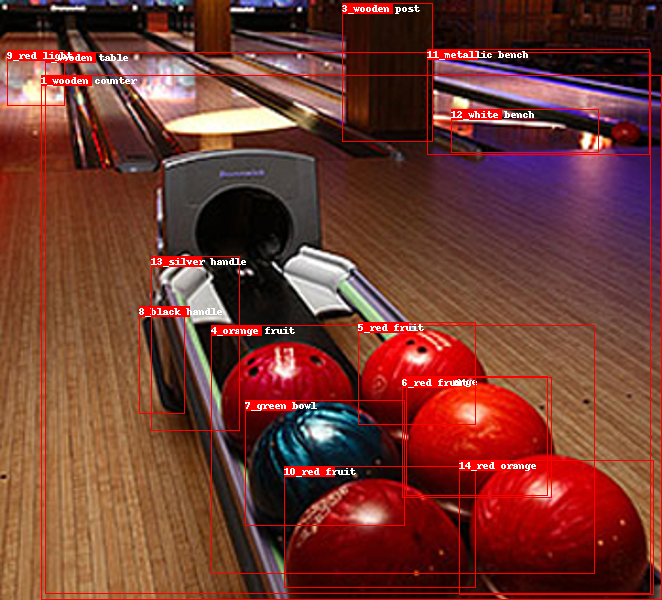

**************************************************
box_labels 0: wooden table; score: 0.35194435715675354
box_labels 1: wooden counter; score: 0.24365241825580597
box_labels 2: red orange; score: 0.11824791133403778
box_labels 3: wooden post; score: 0.09249678999185562
box_labels 4: orange fruit; score: 0.09068939089775085
box_labels 5: red fruit; score: 0.08159127086400986
box_labels 6: red fruit; score: 0.07215937972068787
box_labels 7: green bowl; score: 0.06586235016584396
box_labels 8: black handle; score: 0.06393340229988098
box_labels 9: red light; score: 0.06372438371181488
box_labels 10: red fruit; score: 0.05741569772362709
box_labels 11: metallic bench; score: 0.03947184607386589
box_labels 12: white bench; score: 0.03913776949048042
box_labels 13: silver handle; score: 0.03819133713841438
box_labels 14: red orange; score: 0.037666089832782745
**************************************************
rel_labels 0: 2_red orange => on => 0_wooden table; score: 0.3329738676548004
rel_

In [111]:
image_path = custom_data_info['idx_to_files'][image_idx]
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
box_attrs = custom_prediction[str(image_idx)]['bbox_attrs'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]
    
for i in range(len(box_attrs)):
    attr = ind_to_attributes[np.argmax(box_attrs[i])]
    if attr == 'on':
        idx = np.argsort(box_attrs[i])
        box_attrs[i] = ind_to_attributes[idx[-2]]
    else:
        box_attrs[i] = ind_to_attributes[np.argmax(box_attrs[i])]
        
        
rel_labels = []
rel_scores = []

for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_attrs[all_rel_pairs[i][0]] + ' ' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_attrs[all_rel_pairs[i][1]] + ' ' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

for i in range(len(box_labels)):
    box_labels[i] = box_attrs[i] + ' ' + box_labels[i]

draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)

In [79]:
# testing: retrieve predicate strings from labels

image_path = custom_data_info['idx_to_files'][image_idx]
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]

rel_labels = []
rel_scores = []
for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = box_attrs[all_rel_pairs[i][0]] + ' ' + box_labels[all_rel_pairs[i][0]] + ' ' + ind_to_predicates[all_rel_labels[i]] + ' ' + box_attrs[all_rel_pairs[i][1]] + ' ' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

# draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)

In [99]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('stsb-roberta-base')

# rel_labels = ['white plate on wooden table', 'white plate on wooden table', 'white plate on wooden table', 
#              'white plate near silver fork', 'white plate near white knife','white plate near black knife', 
#              'white plate near black knife', 'white plate near wall']

# rel_labels = ['red apple on yellow box', 'red apple on blue book', 'red apple on orange book', 
#               'blue book on orange book', 'red apple on brown table', 'yellow box on brown table', 
#              'orange book on brown table', 'brown table in white room']

# compute embedding for triplets
# rel_labels = ['yellow plate on wooden table', 'white plate on wooden table']
triplet_embeddings = model.encode(rel_labels, convert_to_tensor=True)

# compute embedding for input text
text = "the top apple"
text_embeddings = model.encode(text, convert_to_tensor=True)

# compute cosine-similarites
cosine_scores = util.pytorch_cos_sim(triplet_embeddings, text_embeddings)
cosine_scores = torch.flatten(cosine_scores)
idx = torch.argsort(cosine_scores)

# print(torch.argsort(cosine_scores))
print(text)
for i in range(-1, -len(rel_labels)-1, -1):
    print("{} Score: {}".format(rel_labels[idx[i]], cosine_scores[idx[i]]))
#Output the pairs with their score
# for i in range(len(rel_labels)):
#     print("{}, {} Score: {}".format(rel_labels[i], text, cosine_scores[i]))


the top apple
red apple on yellow box Score: 0.8232332468032837
red apple on orange book Score: 0.7594720721244812
red apple on brown table Score: 0.731849730014801
red apple on blue book Score: 0.7034313082695007
blue book on orange book Score: 0.313975989818573
yellow box on brown table Score: 0.30527639389038086
orange book on brown table Score: 0.27452749013900757
brown table in white room Score: 0.11108647286891937


In [32]:
# return k pairs with highest similarity scores
k = 3
indices = sorted(range(len(cosine_scores)), key=lambda i: cosine_scores[i])[-k:]
for i in indices:
    print(rel_labels[i])

bag in trunk
bag in trunk
bag in trunk


In [7]:
!pip install transformers
from transformers import BertTokenizer, BertModel
import logging

In [8]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [39]:
# extract sentence embedding from human command
text1 = "yellow book on the shelf"

marked_text = "[CLS] " + text1 + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [0] * len(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

token_vecs = hidden_states[-1][0]
comm_embedding = torch.mean(token_vecs, dim=0)
print(comm_embedding.shape)

torch.Size([768])


In [40]:
# rel_labels
embeddings = []
for label in rel_labels:
    marked = "[CLS] " + label + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [0] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
    token_vecs = hidden_states[-1][0]
    embeddings.append(torch.mean(token_vecs, dim=0))

In [41]:
from scipy.spatial.distance import cosine
diffs = []
for emb in embeddings:
    diffs.append(1 - cosine(comm_embedding, emb))

print(rel_labels[np.argmax(diffs)])

book on table


In [14]:
# scene graph pruning
def prune_sg(target, rel_labels, rel_scores):
    # target = "cup"
    pruned_labels = []
    pruned_scores = []
    for i, label in enumerate(rel_labels):
        if target in label:
            pruned_labels.append(label)
            pruned_scores.append(rel_scores[i])
    return pruned_labels, pruned_scores

In [15]:
def find_target(rel):
    o1, _, _ = rel.split(' => ')
    return o1

def find_relation(rel):
    _, _, o2 = rel.split(' => ')
    return o2

# check if there are multiple targets detected
# labels = box_labels.copy()
# labels.remove('cup')
# if target not in labels:
#     print('there are no duplicate target objs!')
# num_target = box_labels.count(target)

# filter and retrieve {num_target} objects from graph
# return: (list) list of {num_target} relations
def filter_rels(pruned_labels, pruned_scores, num_target):
    target_objs = []
    relation_objs = []
    idxs = []
    for i, label in enumerate(pruned_labels):
    #"rel_labels 1: 0_cup => on => 8_shelf"
        if len(target_objs) == num_target:
            break
        target_obj = find_target(label)
        relation_obj = find_relation(label)
        if not target_objs:
            target_objs.append(target_obj)
            relation_objs.append(relation_obj)
            idxs.append(i)
            continue
        if pruned_scores[i-1] / pruned_scores[i] > 100:
            break
        if (target_obj in target_objs) or (relation_obj in relation_objs):
            continue
        else:  
            target_objs.append(target_obj)
            relation_objs.append(relation_obj)
            idxs.append(i)
    pruned_labels = np.array(pruned_labels)
    return pruned_labels[idxs]

In [16]:
# return strings of (obj, relation, obj)
def breakdown(rel):
    o1, r, o2 = rel.split(' => ')
    return [o1.split('_')[1], r, o2.split('_')[1]]

In [17]:
# print positional info of target objects
# rels: (list) list of relations (relation -> obj)
def ask_back(rels):
    print(f"Do you mean...")
    for i, rel in enumerate(rels):
        o1, r, o2 = breakdown(rel)
        print(f"{i}: {o1} {r} {o2}?")
    # user input index 
    usr_input = int(input("Choose an index: "))
    result = rels[usr_input]
    print(result)
    return result

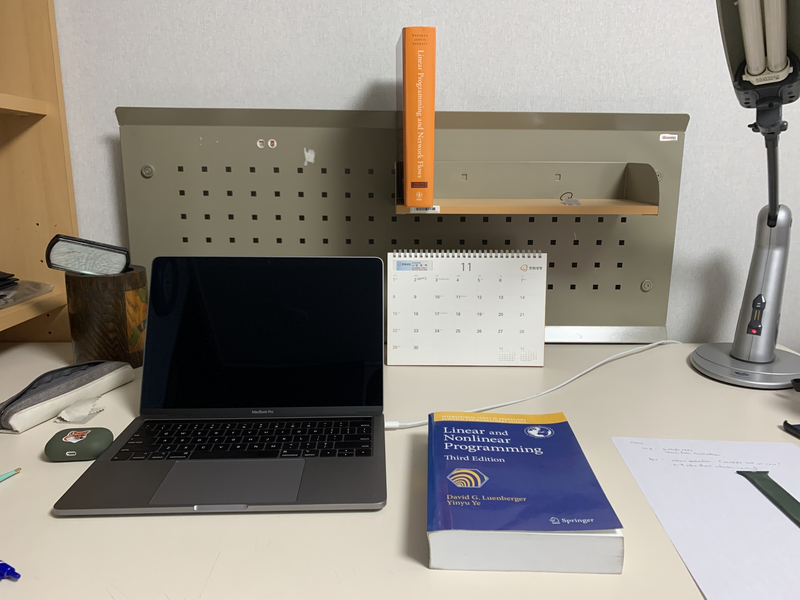

Target object: book
Do you mean...
0: book on desk?
1: book on shelf?
Choose an index: 1
2_book => on => 6_shelf


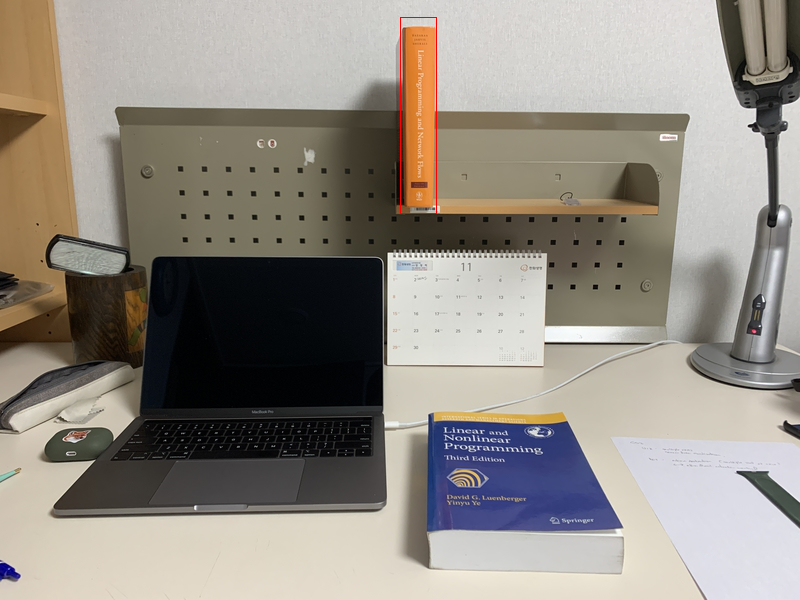

In [18]:
# display image
size = get_size(Image.open(image_path).size)
pic = Image.open(image_path).resize(size)
display(pic)

# ask for target object
target = input("Target object: ")
# prune graph
pruned_labels, pruned_scores = prune_sg(target, rel_labels, rel_scores)
# filter relations
num_target = box_labels.count(target)
filtered_rels = filter_rels(pruned_labels, pruned_scores, num_target)
result = ask_back(filtered_rels)
obj = result.split(" => ")[0]
draw_single_box(pic, boxes[int(obj[0])])
display(pic)